# API

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
import scipy.stats
import matplotlib.pyplot as plt
import time
import pickle
from copy import copy
# %load_ext line_profiler

In [2]:
plt.rcParams['text.usetex']=False
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=9
plt.rcParams['axes.titlesize']=plt.rcParams['font.size']
plt.rcParams['figure.figsize']=(6.8,4)

In [3]:
# ipcluster start --engines=MPI -n 4
import ipyparallel as ipp
rc = ipp.Client()
rc[:].execute("from HOTI import *")
rc[:].execute("import numpy as np")

<AsyncResult: execute>

In [3]:
# %%writefile HOTI.py
import numpy as np
import scipy.linalg as la
import numpy.linalg as nla
import numpy.matlib

class Params:
    def __init__(self,
            Lx=4,
            Ly=16,
            Delta=1,
            t=1,
            m=1,
            l=1,
            bcx=-1,
            bcy=1,
            T=0,
            dxmax=16,
            dymax=16,
            history=False,
            ):
        self.Lx = Lx
        self.Ly = Ly
        self.Delta = Delta
        self.t = t
        self.m = m
        self.bcx = bcx
        self.bcy = bcy
        self.T = T
        self.history = history
        self.sigma0=np.eye(2)
        self.sigmax = np.array([[0, 1], [1, 0]])
        self.sigmay = np.array([[0, -1j], [1j, 0]])
        self.sigmaz = np.array([[1, 0], [0, -1]])
        # check which one is faster, use sparse or dense?
        if Lx<np.inf and Ly<np.inf:
            hopx = np.diag(np.ones(Lx-1), -1)
            hopx[0, -1] = bcx
            hopy = np.diag(np.ones(Ly-1), -1)
            hopy[0, -1] = bcy
            hopxmat = np.kron(np.eye(Ly),hopx)
            hopymat = np.kron(hopy,np.eye(Lx))
            self.hopxmat=hopxmat
            self.hopymat=hopymat
            onsitemat = np.eye(Lx*Ly)

            self.Hamiltonian= (np.kron(hopxmat+hopxmat.T+hopymat+hopymat.T,np.kron(self.sigma0,self.sigmaz)))*t+(np.kron(hopxmat-hopxmat.T,np.kron(self.sigmax,self.sigmax))-np.kron(hopymat-hopymat.T,np.kron(self.sigmay,self.sigmax)))*1j*l+(np.kron(hopxmat+hopxmat.T,np.kron(self.sigma0,self.sigmay))-np.kron(hopymat+hopymat.T,np.kron(self.sigma0,self.sigmay)))*Delta+np.kron(onsitemat,np.kron(self.sigma0,self.sigmaz))*m
    def bandstructure(self):
        val, vec = nla.eigh(self.Hamiltonian)
        sortindex = np.argsort(val)
        self.val = val[sortindex]
        self.vec = vec[:, sortindex]

    def fermi_dist(self, energy, E_F):
        if self.T == 0:
            return np.heaviside(E_F-energy, 0)
        else:
            return 1/(1+np.exp((energy-E_F)/self.T))

    def correlation_matrix(self, E_F=0):
        '''
        G_{ij}=<f_i^\dagger f_j>
        '''
        if not (hasattr(self, 'val') and hasattr(self, 'vec')):
            self.bandstructure()
        occupancy_mat = np.matlib.repmat(self.fermi_dist(self.val, E_F), self.vec.shape[0], 1)
        self.C_f = ((occupancy_mat*self.vec)@self.vec.T.conj())

    def covariance_matrix(self, E_F=0):
        '''
        c.f. notes
        Maybe differs by a minus sign
        '''
        if not hasattr(self, 'C_f'):
            if self.Lx < np.inf and self.Ly<np.inf:
                self.correlation_matrix()
            else:
                self.correlation_matrix_inf_fft()
        G = self.C_f
        Gamma_11 = 1j*(G-G.T)
        Gamma_21 = -(np.eye(G.shape[0])-G-G.T)
        Gamma_12 = -Gamma_21.T
        Gamma_22 = -1j*(G.T-G)
        Gamma = np.zeros((2*G.shape[0], 2*G.shape[0]), dtype=complex)
        even = np.arange(2*G.shape[0])[::2]
        odd = np.arange(2*G.shape[0])[1::2]
        Gamma[np.ix_(even, even)] = Gamma_11
        Gamma[np.ix_(even, odd)] = Gamma_12
        Gamma[np.ix_(odd, even)] = Gamma_21
        Gamma[np.ix_(odd, odd)] = Gamma_22
        assert np.abs(np.imag(Gamma)).max() < 1e-10, "Covariance matrix not real {:.5f}".format(np.abs(np.imag(Gamma)).max())
        self.C_m = np.real(Gamma-Gamma.T.conj())/2
        self.C_m_history = [self.C_m]

    def linearize_index(self, subregion, n, proj=False, k=2):
        '''
        If proj ==True, then the index used for projection operator will be returned
        k, the size of measurement, is useful only when proj=True
        '''
        subregion_x, subregion_y = (subregion)
        subregion_x = np.array(subregion_x)
        subregion_y = np.array(subregion_y)
        
        X, Y = np.meshgrid(subregion_x, subregion_y)
        if self.Ly<np.inf:
            assert subregion_x.max()<self.Lx and subregion_y.max()<self.Ly, 'Range exceeds'
            linear_index = ((X+Y*self.Lx).flatten('F'))
        else:
            assert subregion_x.max()<self.dxmax and subregion_y.max()<self.dymax, 'Range exceeds'
            linear_index = ((X+Y*self.dxmax).flatten('F'))
        if proj:
            return sorted(np.concatenate([n*linear_index+i for i in range(0, n, k)]))
        else:
            return sorted(np.concatenate([n*linear_index+i for i in range(n)]))

    def c_subregion_f(self, subregion, linear=True):
        '''
        subregion: [subregion_x, subregion_y] index of unit cell
        '''
        if not hasattr(self, 'C_f'):
            self.correlation_matrix()
        try:
            subregion = list(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)

        if len(subregion) == 2:
            if isinstance(subregion[0], int) and isinstance(subregion[1], int):
                linear = True
            elif (not isinstance(subregion[0], int)) and (not isinstance(subregion[1], int)):
                linear = False
            else:
                raise ValueError('Illegal subregion')
        else:
            linear = True
        if linear:
            # linearized index
            subregion_index = subregion
        else:
            # 2D index
            subregion_index = self.linearize_index(subregion, 4)
        # This is a dumb way...
        return self.C_f[np.ix_(subregion_index, subregion_index)]

    def von_Neumann_entropy_f(self, subregion):
        c_A = self.c_subregion_f(subregion)
        val = nla.eigvalsh(c_A)
        self.val_sh = val
        val = np.sort(val)
        return np.real(-np.sum(val*np.log(val+1e-18j))-np.sum((1-val)*np.log(1-val+1e-18j)))

    def c_subregion_m(self, subregion, Gamma=None):
            '''
            subregion: [subregoin_x, subregion_y] index of unit cell
            '''
            if not hasattr(self, 'C_m'):
                self.covariance_matrix()
            if Gamma is None:
                Gamma = self.C_m_history[-1]
            try:
                subregion = list(subregion)
            except:
                raise ValueError("The subregion is ill-defined"+subregion)

            if len(subregion) == 2:
                if isinstance(subregion[0], int) and isinstance(subregion[1], int):
                    linear = True
                elif (not isinstance(subregion[0], int)) and (not isinstance(subregion[1], int)):
                    linear = False
                else:
                    raise ValueError('Illegal subregion')
            else:
                linear = True
            if linear:
                # linearized index
                subregion_index = subregion
            else:
                # 2D index
                subregion_index = self.linearize_index(subregion, 8)

            return Gamma[np.ix_(subregion_index, subregion_index)]

    def von_Neumann_entropy_m(self, subregion):
        c_A = self.c_subregion_m(subregion)
        val = nla.eigvalsh(1j*c_A)
        self.val_sh = val
        val = np.sort(val)
        val = (1-val)/2+1e-18j  # \lambda=(1-\xi)/2
        return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

    def mutual_information_f(self, subregion_A, subregion_B):
        subregion_A = self.linearize_index(subregion_A, 4)
        subregion_B = self.linearize_index(subregion_B, 4)
        s_A = self.von_Neumann_entropy_f(subregion_A)
        s_B = self.von_Neumann_entropy_f(subregion_B)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        s_AB = self.von_Neumann_entropy_f(subregion_AB)
        return s_A+s_B-s_AB

    def mutual_information_m(self, subregion_A, subregion_B):
        subregion_A = self.linearize_index(subregion_A, 8)
        subregion_B = self.linearize_index(subregion_B, 8)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        s_A = self.von_Neumann_entropy_m(subregion_A)
        s_B = self.von_Neumann_entropy_m(subregion_B)
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        s_AB = self.von_Neumann_entropy_m(subregion_AB)
        return s_A+s_B-s_AB

    def entropy_E(self, subregion_A, subregion_B):
        subregion_A = self.linearize_index(subregion_A, 8)
        subregion_B = self.linearize_index(subregion_B, 8)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        s_A = self.von_Neumann_entropy_m(subregion_A)
        s_B = self.von_Neumann_entropy_m(subregion_B)
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        s_AB = self.von_Neumann_entropy_m(subregion_AB)
        return s_A+s_B-s_AB

    def log_neg(self, subregion_A, subregion_B, Gamma=None,linear=False):
        if not linear:
            subregion_A = self.linearize_index(subregion_A, 8)
            subregion_B = self.linearize_index(subregion_B, 8)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()

        if Gamma is None:
            Gamma = self.C_m_history[-1]
        subregion_A = np.array(subregion_A)
        subregion_B = np.array(subregion_B)
        Gm_p = np.block([
            [-Gamma[np.ix_(subregion_A, subregion_A)], 1j *
             Gamma[np.ix_(subregion_A, subregion_B)]],
            [1j*Gamma[np.ix_(subregion_B, subregion_A)],
             Gamma[np.ix_(subregion_B, subregion_B)]]
        ])
        Gm_n = np.block([
            [-Gamma[np.ix_(subregion_A, subregion_A)], -1j *
             Gamma[np.ix_(subregion_A, subregion_B)]],
            [-1j*Gamma[np.ix_(subregion_B, subregion_A)],
             Gamma[np.ix_(subregion_B, subregion_B)]]
        ])
        idm = np.eye(Gm_p.shape[0])
        # Gm_x=idm-(idm+1j*Gm_p)@nla.inv(idm-Gm_n@Gm_p)@(idm+1j*Gm_n)
        Gm_x = idm-(idm+1j*Gm_p)@(la.solve((idm-Gm_n@Gm_p), (idm+1j*Gm_n)))
        Gm_x = (Gm_x+Gm_x.T.conj())/2
        xi = nla.eigvalsh(Gm_x)
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        eA = np.sum(np.log(((1+xi+0j)/2)**0.5+((1-xi+0j)/2)**0.5))/2
        chi = nla.eigvalsh(1j*Gamma[np.ix_(subregion_AB, subregion_AB)])
        sA = np.sum(np.log(((1+chi)/2)**2+((1-chi)/2)**2))/4
        self.eA=eA
        self.sA=sA
        return np.real(eA+sA)

    def projection(self, s,type='onsite',ignore=False):
        '''
        For type:'onsite'
            occupancy number: s= 0,1 
            (-1)^0 even parity, (-1)^1 odd parity
        For type:'link'
            (o,+)|(o,-)|(e,+)|(e,-)
        '''
        if type=='onsite':
            assert (s == 0 or s == 1), "s={} is either 0 or 1".format(s)
            blkmat = np.array([[0, -(-1)**s, 0, 0],
                            [(-1)**s, 0, 0, 0],
                            [0, 0, 0, (-1)**s],
                            [0, 0, -(-1)**s, 0]])
            return blkmat

        if type=='correlated':
            assert (s in ['10','01']), "s={} for {} is not defined".format(s,type)
            if s=='10':
                blkmat=np.array([[0,-1,0,0],
                                 [1,0,0,0],
                                 [0,0,0,1],
                                 [0,0,-1,0]])
            if s=='01':
                blkmat=np.array([[0,1,0,0],
                                 [-1,0,0,0],
                                 [0,0,0,-1],
                                 [0,0,1,0]])
            proj=np.zeros((8,8))
            proj[:4,:4]=blkmat
            proj[4:,4:]=blkmat.T
            return proj

        if type=='link':
            raise ValueError('UnderConstruction')
            assert (s in ['o+','o-','e+','e-']), "s={} for {} is not defined".format(s,type)
            if s=='o+':
                antidiag=[1,-1,1,-1]
                blkmat=np.diag(antidiag)
                blkmat=np.fliplr(blkmat)
            if s=='o-':
                antidiag=[-1,1,-1,1]
                blkmat=np.diag(antidiag)
                blkmat=np.fliplr(blkmat)
            if not ignore:
                if s=='e+':
                    blkmat=np.array([[0,-1,0,0],
                                    [1,0,0,0],
                                    [0,0,0,-1],
                                    [0,0,1,0]])
                if s=='e-':
                    blkmat=-np.array([[0,-1,0,0],
                                    [1,0,0,0],
                                    [0,0,0,-1],
                                    [0,0,1,0]])
            else:
                if s=='e+':
                    antidiag=[-1,-1,1,1]
                    blkmat=np.diag(antidiag)
                    blkmat=np.fliplr(blkmat)
                if s=='e-':
                    antidiag=[1,1,-1,-1]
                    blkmat=np.diag(antidiag)
                    blkmat=np.fliplr(blkmat)
            proj=np.zeros((8,8))
            proj[:4,:4]=blkmat
            proj[4:,4:]=blkmat.T
            return proj            
        raise ValueError("type '{}' is not defined".format(type))

    def measure(self, s, ix,type='onsite',ignore=False):
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if not hasattr(self, 's_history'):
            self.s_history = []
        if not hasattr(self, 'i_history'):
            self.i_history = []

        mat = self.C_m_history[-1].copy()

        for i_ind, i in enumerate(ix):
            mat[[i, -(len(ix)-i_ind)]] = mat[[-(len(ix)-i_ind), i]]
            mat[:, [i, -(len(ix)-i_ind)]] = mat[:, [-(len(ix)-i_ind), i]]

        self.mat = mat

        Gamma_LL = mat[:-len(ix), :-len(ix)]
        Gamma_LR = mat[:-len(ix), -len(ix):]
        Gamma_RR = mat[-len(ix):, -len(ix):]

        proj = self.projection(s,type=type,ignore=ignore)
        Upsilon_LL = proj[:-len(ix), :-len(ix)]
        Upsilon_RR = proj[-len(ix):, -len(ix):]
        Upsilon_RL = proj[-len(ix):, :-len(ix)]
        zero = np.zeros((mat.shape[0]-len(ix), len(ix)))
        zero0 = np.zeros((len(ix), len(ix)))
        mat1 = np.block([[Gamma_LL, zero], [zero.T, Upsilon_RR]])
        mat2 = np.block([[Gamma_LR, zero], [zero0, Upsilon_RL]])
        mat3 = np.block([[Gamma_RR, np.eye(len(ix))],
                        [-np.eye(len(ix)), Upsilon_LL]])
        self.mat2 = mat2
        if np.count_nonzero(mat2):
            Psi = mat1+mat2@(la.solve(mat3, mat2.T))
            # Psi=mat1+mat2@(la.lstsq(mat3,mat2.T)[0])
            assert np.abs(
                np.trace(Psi)) < 1e-5, "Not trace zero {:e}".format(np.trace(Psi))
        else:
            Psi = mat1

        for i_ind, i in enumerate(ix):
            Psi[[i, -(len(ix)-i_ind)]] = Psi[[-(len(ix)-i_ind), i]]
            Psi[:, [i, -(len(ix)-i_ind)]] = Psi[:, [-(len(ix)-i_ind), i]]
        Psi = (Psi-Psi.T)/2   # Anti-symmetrize
        if self.history:
            self.C_m_history.append(Psi)
            self.s_history.append(s)
            self.i_history.append(ix[0])
        else:
            self.C_m_history = [Psi]
            self.s_history = [s]
            self.i_history = [ix[0]]

    def measure_all_Born(self, proj_range,prob=None,linear=False,type='onsite',pool=4,ignore=False):
        if not linear:
            if type=='onsite':
                proj_range = self.linearize_index(proj_range, 8, proj=True)
            if type=='correlated':
                proj_range = self.linearize_index(proj_range, 4, proj=True,k=4)
                
            # if type=='link':
            #     proj_range = self.linearize_index(proj_range, 8, proj=True,k=8)
        # self.proj_range=proj_range
        # print(proj_range)
        self.P_0_list = []
        self.f_parity= []
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if type=='onsite':
            for index,i in enumerate(proj_range):
                if prob is None:
                    P_0 = (self.C_m_history[-1][i, i+1]+1)/2    # Use Born rule
                else:
                    if isinstance(prob,list):
                        assert len(prob)==len(proj_range), "len of prob {:d} not equal to len of proj_range {:d}".format(len(prob),len(proj_range))
                        P_0=prob[index]
                    else:    
                        P_0=prob
                self.P_0_list.append(P_0)
                if np.random.rand() < P_0:
                    self.measure(0, [i, i+1])
                    self.f_parity.append(0)
                else:
                    self.measure(1, [i, i+1])
                    self.f_parity.append(1)
            return self

        if type=='correlated':
            for i in proj_range:
                Gamma=self.C_m_history[-1][i:i+4,i:i+4]
                P={}
                if prob is None:
                    gamma1234=-Gamma[0,1]*Gamma[2,3]+Gamma[0,2]*Gamma[1,3]-Gamma[0,3]*Gamma[1,2]
                    P['10']=(1+Gamma[0,1]-Gamma[2,3]+gamma1234)/4
                    P['01']=(1-Gamma[0,1]+Gamma[2,3]+gamma1234)/4
                else:
                    P['10'],P['01']=tuple(prob)
                s=np.random.choice(['10','01'],p=[P['10']/(P['10']+P['01']),P['01']/(P['10']+P['01'])])
                self.measure(s,[i,i+1,i+2,i+3],type=type)
            return self
        # if type=='link':
        #     for i in proj_range:
        #         Gamma=self.C_m_history[-1][i:i+4,i:i+4]
        #         P={}
        #         if prob is None:
        #             gamma1234=-Gamma[0,1]*Gamma[2,3]+Gamma[0,2]*Gamma[1,3]-Gamma[0,3]*Gamma[1,2]
        #             P['o+']=(1+Gamma[1,2]-Gamma[0,3]+gamma1234)/4
        #             P['o-']=(1-Gamma[1,2]+Gamma[0,3]+gamma1234)/4
        #             if not ignore:
        #                 P['e+']=(1+Gamma[0,1]+Gamma[2,3]-gamma1234)/4
        #                 P['e-']=(1-Gamma[0,1]-Gamma[2,3]-gamma1234)/4
        #             else:
        #                 #ignore symmetry
        #                 P['e+']=(1+Gamma[1,2]+Gamma[0,3]-gamma1234)/4
        #                 P['e-']=(1-Gamma[1,2]-Gamma[0,3]-gamma1234)/4
        #         else:
        #             P['o+'],P['o-'],P['e+'],P['e-']=tuple(prob)

        #         # print((P.values()))
        #         if pool==4:
        #             s=np.random.choice(['o+','o-','e+','e-'],p=[P['o+'],P['o-'],P['e+'],P['e-']])
        #         elif pool==2:
        #             s=np.random.choice(['o+','o-'],p=[P['o+']/(P['o+']+P['o-']),P['o-']/(P['o+']+P['o-'])])
        #         elif pool==-2:
        #             s=np.random.choice(['e+','e-'],p=[P['e+']/(P['e+']+P['e-']),P['e-']/(P['e+']+P['e-'])])
        #         self.measure(s,[i,i+1,i+2,i+3],type='link',ignore=ignore)
        #     return self
    def fermion_number(self,proj_range,linear=False,type='C_m'):
        if type=='C_m':
            if not linear:
                proj_range = self.linearize_index(proj_range, 8, proj=True,k=2)
            return 1/2*(1-np.diagonal(self.C_m_history[-1],1)[proj_range]).sum()
        # if type=='C_f':
        #     if not linear:
        #         proj_range = self.linearize_index(proj_range, 2, proj=True,k=1)
        #     return np.trace(self.C_f[proj_range])


# Band structure

In [73]:
m_list=np.linspace(1,3,11)
val_map=[]
for m in m_list:
    params=Params(m=m,t=.5,l=.5,Delta=0.25,Lx=20,Ly=20,bcx=1,bcy=1)
    params.bandstructure()
    val_map.append(params.val)

val_map=np.array(val_map)



 ...]

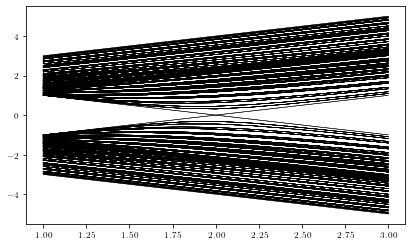

In [74]:
plt.plot(m_list,val_map,'k',lw=.5)


In [9]:
params=Params(m=1,t=.5,l=.5,Delta=0.25,Lx=20,Ly=10,bcx=0,bcy=0)
params.bandstructure()
params.correlation_matrix()
params.val[params.val.shape[0]//2-4:params.val.shape[0]//2+4]

array([-0.46309468, -0.46309468, -0.00168874, -0.00168874,  0.00168874,
        0.00168874,  0.46309468,  0.46309468])

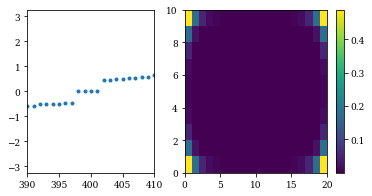

In [10]:
fig,ax=plt.subplots(1,2,figsize=(6,3),gridspec_kw=dict(width_ratios=[1,1.4]))
ax[0].plot(params.val,'.')
ax[0].set_xlim([params.val.shape[0]//2-10,params.val.shape[0]//2+10])

ldos=0
for index in range(params.val.shape[0]//2-2,params.val.shape[0]//2+2):
    ldos+=(params.vec[:,index].reshape((params.Ly,params.Lx,4)).sum(axis=2).__abs__())**2
im=ax[1].pcolormesh(ldos)
cb=fig.colorbar(im)

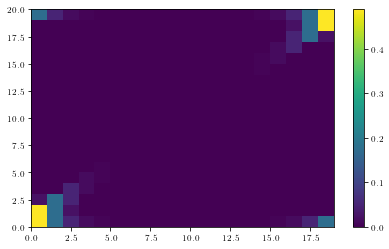

In [102]:
index=params.val.shape[0]//2-2
ldos=0
fig,ax=plt.subplots()
for index in range(params.val.shape[0]//2-2,params.val.shape[0]//2+2):
    ldos+=(params.vec[:,index].reshape((params.Lx,params.Ly,4)).sum(axis=2).__abs__())**2
im=ax.pcolormesh(ldos)
cb=fig.colorbar(im)

In [31]:
params.Lx*params.Ly

400

In [44]:
np.arange(24).reshape((2,3,4))

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

# Entanglement spectrum

In [11]:
params_pbc=Params(m=1,t=.5,l=.5,Delta=.25,Lx=20,Ly=20,bcx=-1,bcy=-1)

In [176]:
cf1=params_pbc.c_subregion_f([np.arange(params_pbc.Lx//2),np.arange(params_pbc.Ly)])
cf1_val,cf1vec=nla.eigh(cf1)

In [177]:
cm1=params_pbc.c_subregion_m([np.arange(params_pbc.Lx//2),np.arange(params_pbc.Ly)])
cm1_val,cm1vec=nla.eigh(cm1)

(790.0, 810.0)

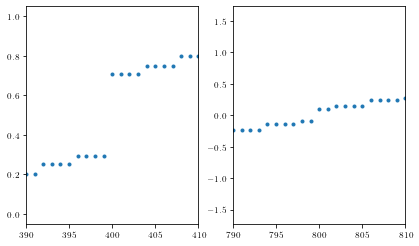

In [178]:
fig,ax=plt.subplots(1,2)
ax[0].plot(cf1_val,'.')
ax[0].set_xlim(cf1_val.shape[0]//2-10,cf1_val.shape[0]//2+10)

ax[1].plot(cm1_val,'.')
ax[1].set_xlim(cm1_val.shape[0]//2-10,cm1_val.shape[0]//2+10)

In [33]:
# cf2=params_pbc.c_subregion_f([np.arange(params_pbc.Lx//2),np.arange(params_pbc.Ly//2)])
cf2=params_pbc.c_subregion_f([np.arange(6),np.arange(12)])
cf2_val,cf2vec=nla.eigh(cf2)

In [22]:
# cm2=params_pbc.c_subregion_m([np.arange(params_pbc.Lx//2),np.arange(params_pbc.Ly//2)])
cm2=params_pbc.c_subregion_m([np.arange(6),np.arange(12)])
cm2_val,cf2vec=nla.eigh(cm2)

(278.0, 298.0)

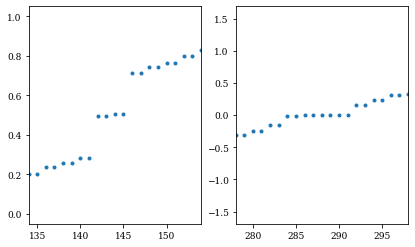

In [20]:
fig,ax=plt.subplots(1,2)
ax[0].plot(cf2_val,'.')
ax[0].set_xlim(cf2_val.shape[0]//2-10,cf2_val.shape[0]//2+10)

ax[1].plot(cm2_val,'.')
ax[1].set_xlim(cm2_val.shape[0]//2-10,cm2_val.shape[0]//2+10)

In [34]:
cf2.shape

(288, 288)

In [35]:
cf2vec.shape

(288, 288)

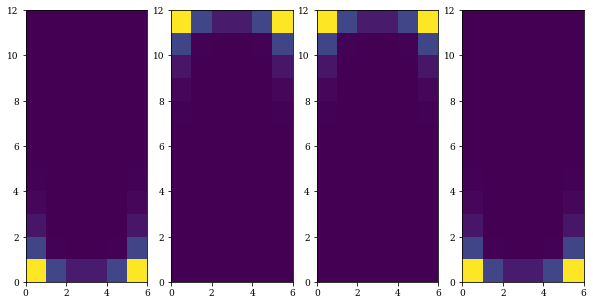

In [43]:
fig,ax=plt.subplots(1,4,figsize=(10,5))

for index,i in enumerate(range(-2,2)):
    wf=cf2vec[:,cf2vec.shape[0]//2+i].reshape((12,6,4))
    ax[index].pcolormesh(np.sum(np.abs(wf[:,:])**2,axis=2))

# Von Nuewmann entropy

In [390]:
params=Params(m=1,t=.5,l=.5,Delta=.25,Lx=32,Ly=32,bcx=1,bcy=1)


In [393]:
len_list=np.arange(1,params.Lx//2)
vE_list=np.zeros(len_list.shape[0])
for i in len_list:
    vE_list[i-1]=(params.von_Neumann_entropy_f([np.arange(i),np.arange(i)]))

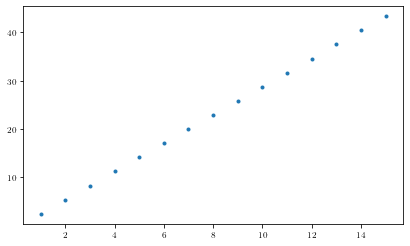

In [394]:
plt.plot((len_list),(vE_list),'.')

In [398]:
mask=(len_list>=4)
lr=scipy.stats.linregress(len_list[mask]*4,(vE_list[mask]))


In [399]:
np.array([lr.slope,lr.intercept])/np.log(2)

array([ 1.05493132, -0.77102967])

In [125]:
params.von_Neumann_entropy_m([np.arange(1),np.arange(params.Ly)])

15.062165269357127

In [128]:
vE_list[1]

15

# No measurement

In [182]:
params=Params(m=2,t=.5,l=.5,Delta=0.25,Lx=32,Ly=32,bcx=-1,bcy=-1)

In [184]:
params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly//4)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly//4)])

0.03764392787734572

In [183]:
params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly//4)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly//4)])

0.041365351281694274

In [362]:
m_list=np.linspace(1,3,11)
LN_list=[]
MI_list=[]
for m in m_list:
    params=Params(m=m,t=.5,l=.5,Delta=0.25,Lx=24,Ly=24,bcx=1,bcy=1)
    MI_list.append(params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly//4)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly//4)]))
    LN_list.append(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly//4)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly//4)]))



Text(0, 0.5, '[log 2]')

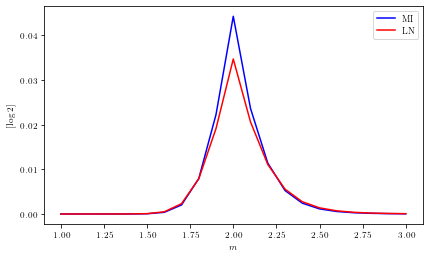

In [364]:
fig,ax=plt.subplots()
ax.plot(m_list,MI_list,'b',label='MI')
ax.plot(m_list,LN_list,'r',label='LN')
ax.legend()
ax.set_xlabel('$m$')
ax.set_ylabel('[log 2]')

# Born measurement

In [ ]:
params=Params(m=10,t=.5,l=.5,Delta=0.25,Lx=32,Ly=32,bcx=-1,bcy=-1)
subA=[np.arange(params.Lx//4),np.arange(params.Ly//4)]
subAp=[np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly//4)]
subB=[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly//4)]

# params.measure_all_Born(subAp)
# params.mutual_information_m(subA,subB)
# params.log_neg(subA,subB)

0.11080397109652118

In [85]:
params=Params(m=10,t=.5,l=.5,Delta=0.25,Lx=24,Ly=24,bcx=-1,bcy=-1)


In [86]:
params.correlation_matrix()

In [87]:
np.diag(params.C_f)[0:10]

array([0.00315322+0.j, 0.99684678+0.j, 0.00315322+0.j, 0.99684678+0.j,
       0.00315322+0.j, 0.99684678+0.j, 0.00315322+0.j, 0.99684678+0.j,
       0.00315322+0.j, 0.99684678+0.j])

In [25]:
def run(p):
    Lx,Ly,m,prob=p
    params=Params(m=1,t=.5,l=.5,Delta=0.25,Lx=Lx,Ly=Ly,bcx=-1,bcy=-1)
    subA=[np.arange(params.Lx//4),np.arange(params.Ly//4)]
    subAp=[np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly//4)]
    subB=[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly//4)]
    # prob=[1,0]*(2*params.Lx//4*params.Ly//4)
    params.measure_all_Born(subAp,prob=prob)
    # MI=params.mutual_information_m(subA,subB)
    LN=params.log_neg(subA,subB)
    # return MI,LN
    return LN

In [15]:
Lx=20
Ly=20
prob=[1,0]*(2*Lx//4*Ly//4)
run((Lx,Ly,1,prob))

(0.23778175341634977, 0.198589286248108)

In [9]:
Lx=24
Ly=24
prob=[1,0]*(2*Lx//4*Ly//4)
run((Lx,Ly,1,prob))

(0.23802484791222867, 0.19304894101351344)

In [13]:
Lx=32
Ly=32
prob=[1,0]*(2*Lx//4*Ly//4)
run((Lx,Ly,1,prob))

(0.2382134860143026, 0.18726214669890773)

In [14]:
Lx=48
Ly=48
prob=[1,0]*(2*Lx//4*Ly//4)
run((Lx,Ly,1,prob))

(0.23827375728995293, 0.18321194141826425)

In [16]:
Lx=20
Ly=20
prob=[1,0]*(2*Lx//4*Ly//4)
prob[10],prob[11]=prob[11],prob[10]
run((Lx,Ly,1,prob))

(0.23141517885822793, 0.19300042621519609)

In [11]:
Lx=24
Ly=24
prob=[1,0]*(2*Lx//4*Ly//4)
prob[0],prob[1]=prob[1],prob[0]
prob[2],prob[3]=prob[3],prob[2]
run((Lx,Ly,1,prob))

(0.23683946786431775, 0.1867763214278284)

In [17]:
prob=[1,0]*(2*Lx//4*Ly//4)
prob_list=[prob]
prob1=copy(prob)
for i in range(2*Lx//4*Ly//4):
    prob1[2*i],prob1[2*i+1]=prob1[2*i+1],prob1[2*i]
    prob2=copy(prob1)
    prob_list.append(prob2)

In [26]:
Lx=20
Ly=20
inputs=[(Lx,Ly,1,prob) for prob in prob_list[:]]
LN_samesite_list=np.zeros(len(prob_list))
fn_samesite_list=np.zeros(len(prob_list))

sync=rc[:].map_sync(run,inputs)
for es_i,result in enumerate(sync):
    LN=result
    LN_samesite_list[es_i]=(LN)
    # fn_samesite_list[es_i]=(fn)

In [27]:
LN_samesite_list

array([0.19858932, 0.19692903, 0.1954456 , 0.18953166, 0.21692442,
       0.20161777, 0.13334136, 0.19917787, 0.2016472 , 0.23076488,
       0.23218488, 0.22904538, 0.30661944, 0.23060324, 0.32818362,
       0.22373532, 0.34948337, 0.2183061 , 0.3268006 , 0.22240315,
       0.2258626 , 0.21997299, 0.36117528, 0.21040891, 0.40690087,
       0.22968258, 0.49894351, 0.21890739, 0.46916995, 0.2537552 ,
       0.27542222, 0.2615031 , 0.33761503, 0.27521211, 0.3328388 ,
       0.28346364, 0.38270836, 0.30263679, 0.41917517, 0.31574019,
       0.35140963, 0.30344772, 0.26185602, 0.26716377, 0.166754  ,
       0.26034795, 0.20326112, 0.26417571, 0.22358049, 0.24200467,
       0.24550654])

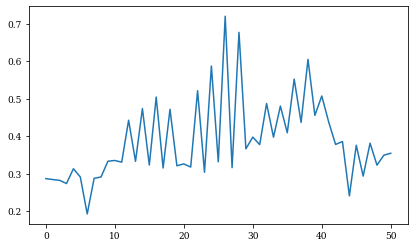

In [29]:
plt.plot(LN_samesite_list/np.log(2))

In [47]:
def run(p):
    Lx,Ly,m,prob,A_y,Ap_y,B_y=p
    params=Params(m=1,t=.5,l=.5,Delta=0.25,Lx=Lx,Ly=Ly,bcx=-1,bcy=-1)
    subA=[np.arange(params.Lx//4),A_y]
    subAp=[np.arange(params.Lx//4)+params.Lx//4,Ap_y]
    subB=[np.arange(params.Lx//4)+params.Lx//2,B_y]
    # prob=[1,0]*(2*params.Lx//4*params.Ly//4)
    params.measure_all_Born(subAp,prob=prob)
    MI=params.mutual_information_m(subA,subB)
    LN=params.log_neg(subA,subB)
    return MI,LN
    # return LN


In [48]:
Lx=20
Ly=20
prob=[1,0]*(2*Lx//4*Ly//4)

run((Lx,Ly,1,prob,np.arange(Ly//4),np.arange(Ly//4)+Ly//4,np.arange(Ly//4)+Ly//2))

(1.0387731872896211e-05, 6.390417572887941e-06)

In [ ]:
# is there area law here? 
# if so, how to eliminate? by thin 

In [74]:
Lx=20
Ly=20
prob=[1,0]*(2*Lx//4*Ly//4)

run((Lx,Ly,1,prob,np.arange(Ly//4),np.arange(Ly//4),np.arange(Ly//4)))

(0.23778175341634977, 0.198589286248108)

In [59]:
Lx=20
Ly=20
prob=[1,0]*(2*Lx//4*Ly//4)

run((Lx,Ly,1,prob,np.arange(Ly//4),np.arange(Ly//4)+1,np.arange(Ly//4)))

0.16060922039007508

In [60]:
Lx=20
Ly=20
prob=[1,0]*(2*Lx//4*Ly//2)

run((Lx,Ly,1,prob,np.arange(Ly//2),np.arange(Ly//2),np.arange(Ly//2)))

0.8232124561216985

In [61]:
Lx=20
Ly=20
prob=[1,0]*(2*Lx//4*Ly//1)

run((Lx,Ly,1,prob,np.arange(Ly),np.arange(Ly),np.arange(Ly)))

2.708168931880884

In [64]:
Lx=20
Ly=20
prob=[1,0]*(2*Lx//4*(Ly-1))

run((Lx,Ly,1,prob,np.arange(Ly-1),np.arange(Ly-1),np.arange(Ly-1)))

2.047272723469261

In [94]:
y_list=np.arange(1,10)


In [35]:
Lx=20
Ly=20
MI_list=[]
LN_list=[]
y_list=np.arange(1,Ly+1)
for y in y_list:
    prob=[1,0]*(2*Lx//4*y)
    MI,LN=run((Lx,Ly,1,prob,np.arange(y),np.arange(y),np.arange(y)))
    MI_list.append(MI)
    LN_list.append(LN)

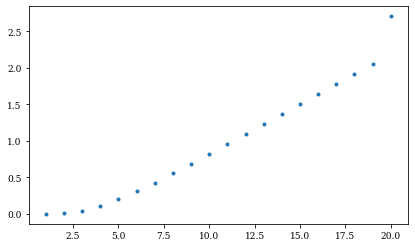

In [36]:
plt.plot(y_list,LN_list,'.')

In [46]:
mask=((y_list)>5 & (y_list<20))

lr=scipy.stats.linregress((y_list)[mask],(np.array(LN_list)[mask]))


In [47]:
[lr.slope,lr.intercept]

[0.13531758961523732, -0.4681574259048231]

In [48]:
-0.4681574259048231/np.log(2)

-0.6754083967082307

In [19]:
params=Params(m=1,t=.5,l=.5,Delta=0.25,Lx=32,Ly=32,bcx=1,bcy=1)
subA=[np.arange(params.Lx//4),np.arange(params.Ly//4)]
subAp=[np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly//4)]
subB=[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly//4)]
prob=[1,0]*(2*params.Lx//4*params.Ly//4)
params.measure_all_Born(subAp,prob)
[params.mutual_information_m(subA,subB)/np.log(2),params.log_neg(subA,subB)/np.log(2)]

[0.3436694149437181, 0.2701627048897507]

In [12]:
(np.log(2)-.5)

0.1931471805599453

In [16]:
params.log_neg(subA,subB)

0.19304853632922025

In [11]:
nocc=1/2*(1-(np.diag(params.C_m_history[-1],1)[::2])).reshape((params.Ly,params.Lx,4))

In [351]:
nocc=1/2*(1-(np.diag(params.C_m_history[-1],1)[::2]))

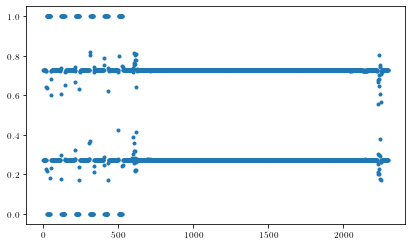

In [352]:
plt.plot(nocc.reshape((-1,1)),'.')

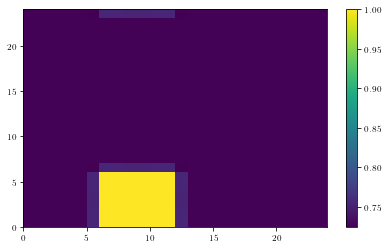

In [15]:
plt.pcolormesh(nocc[:,:,3])
plt.colorbar()

In [263]:
params.fermion_number(subAp)

72.0

In [208]:
params.Lx//4*params.Ly//4*4/2

72.0

In [193]:
[params.mutual_information_m(subA,subB)/np.log(2),params.log_neg(subA,subB)/np.log(2)]


[0.8336413707968007, 0.5442038651450922]

In [228]:
es=50
Lx=24
Ly=24
mN=11
with open('/mnt/d/KITP/Rp_SPT/13/HOTI_Born_es{:d}_Lx{:d}_Ly{:d}_mN{:d}.pickle'.format(es,Lx,Ly,mN),'rb') as f:
        [m_list,MI_list,LN_list,fn_list]=pickle.load(f)

In [229]:
m_list

array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ])

In [ ]:
MI_list

Text(0, 0.5, '[log 2]')

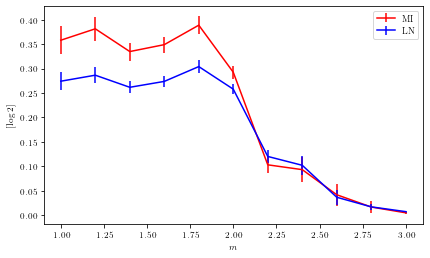

In [285]:
fig,ax=plt.subplots()
ax.errorbar(m_list,MI_list.mean(axis=1)/np.log(2),MI_list.std(axis=1)/np.log(2)/np.sqrt(es),color='r',label='MI')
ax.errorbar(m_list,LN_list.mean(axis=1)/np.log(2),LN_list.std(axis=1)/np.log(2)/np.sqrt(es),color='b',label='LN')
# ax.plot(m_list,LN_half_mean_list,color='y')
ax.set_xlabel('$m$')
ax.legend()
ax.set_ylabel('[log 2]')

Text(0, 0.5, '[log 2]')

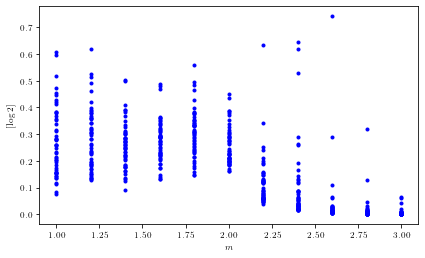

In [290]:
fig,ax=plt.subplots()
# ax.plot(m_list,MI_list/np.log(2),'.r')
ax.plot(m_list,LN_list/np.log(2),'.b')
# ax.errorbar(m_list,LN_list.mean(axis=1)/np.log(2),LN_list.std(axis=1)/np.log(2)/np.sqrt(es),color='b',label='LN')
# ax.plot(m_list,LN_half_mean_list,color='y')
ax.set_xlabel('$m$')
ax.set_ylabel('[log 2]')

In [241]:
LN_list[0]/np.log(2)

array([0.15484168, 0.33800161, 0.38364715, 0.21072409, 0.47101683,
       0.60676813, 0.11885021, 0.37702861, 0.31533037, 0.25998448,
       0.15746678, 0.07672568, 0.14287695, 0.41092328, 0.17465255,
       0.13414964, 0.20172094, 0.2831965 , 0.13515118, 0.18260946,
       0.20290338, 0.22859598, 0.4263527 , 0.35104726, 0.19525617,
       0.15443667, 0.27846227, 0.14352724, 0.24826754, 0.23415327,
       0.15298297, 0.4468939 , 0.2923901 , 0.08199279, 0.28212282,
       0.45513235, 0.35762027, 0.11325761, 0.25781701, 0.15399139,
       0.25843683, 0.38289717, 0.42178947, 0.16640503, 0.59600041,
       0.28200072, 0.31189891, 0.51777252, 0.21284644, 0.36721382])

In [248]:
LN_half_mean_list=[LN[fn==72].mean()/np.log(2) for LN,fn in zip(LN_list,fn_list)]

# A ,B adjacent

In [405]:
params=Params(m=3,t=.5,l=.5,Delta=0.25,Lx=24,Ly=24,bcx=-1,bcy=-1)
subA=[np.arange(params.Lx//4),np.arange(params.Ly//4)]
subB=[np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly//4)]

In [406]:
[params.mutual_information_m(subA,subB)/np.log(2),params.log_neg(subA,subB)/np.log(2)]

[3.4032947658798065, 5.235688677222684]

In [407]:
m_list=np.linspace(1,3,11)
LN_list=[]
MI_list=[]
for m in m_list:
    params=Params(m=m,t=.5,l=.5,Delta=0.25,Lx=24,Ly=24,bcx=1,bcy=1)
    MI_list.append(params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly//4)],[np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly//4)]))
    LN_list.append(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly//4)],[np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly//4)]))



Text(0, 0.5, '[log 2]')

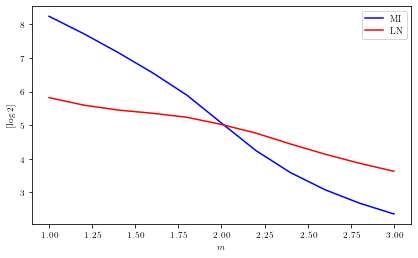

In [408]:
fig,ax=plt.subplots()
ax.plot(m_list,MI_list,'b',label='MI')
ax.plot(m_list,LN_list,'r',label='LN')
ax.legend()
ax.set_xlabel('$m$')
ax.set_ylabel('[log 2]')